# via connection to plane example

In [2]:
using FastHenryHelper

In [3]:
const height = 1.6      # 63mil PCB
const cu_sigma = 5.8e4
# const cu_thick = 0.035  # 1oz copper
const cu_thick = 0.5    # exaggerate thickness

function via_connection_to_plane_example(height, cu_thick)
    t = Comment("via connection to plane example")
    u = Units("mm")
    
    # create a via with 16 segments
    # topequiv = false, botequiv = false will allow each segment 
    # to connect to the plane separately
    via = viagroup(radius=2, height=height, h=cu_thick, nhinc = 1,
                   sigma=cu_sigma, n=16, topequiv = false, botequiv = false)
    
    # move via into position
    transform!(via, txyz(3.0,5.0,0.0))
    
    # create a line of nodes along what will be the right side of the plane
    top_port = Array{Node}(undef, 50)
    y = 0.0
    for i in eachindex(top_port) 
        top_port[i] = Node(10.0,y,0.0)
        y += 0.2
    end
    
    # short the line of vias.  This will be one terminal of the external port.
    top_port_equiv = Equiv(top_port)
    
    # planeconnect retuns a deepcopy of the nodes, and a group of equiv's to
    # connect them to the original nodes.
    # via[:alltop] is an array of the 16 nodes around the top on the via
    (top_plane_nodes, top_plane_nodes_equiv_group) = planeconnect(via[:alltop])
    
    
    # create a plane with 100x100 segments.
    # nodes connect to the external port and the top of the via
    topplane = UniformPlane(
        x1=10.0, y1= 10.0, z1=0.0,
        x2= 0.0, y2= 10.0, z2=0.0,
        x3= 0.0, y3= 0.0, z3=0.0,
        thick = cu_thick,
        seg1=100, seg2=100,
        sigma = cu_sigma,
        nhinc = 5,
        nodes = [top_plane_nodes;top_port])

    # repeat for the bottom plane
    bot_port = Array{Node}(undef, 50)
    y = 0.0
    for i in eachindex(bot_port) 
        bot_port[i] = Node(10.0,y,-height)
        y += 0.2
    end
    bot_port_equiv = Equiv(bot_port)
    (bot_plane_nodes,bot_plane_nodes_equiv_group) = planeconnect(via[:allbot])
    botplane = UniformPlane(
        x1= 0.0, y1= 0.0, z1=-height,
        x2= 0.0, y2=10.0, z2=-height,
        x3=10.0, y3=10.0, z3=-height,
        thick = cu_thick,
        seg1=100, seg2=100,
        sigma = cu_sigma,
        nhinc = 5,
        nodes = [bot_plane_nodes;bot_port])

    # define the external port between the two lines of nodes
    ex = External(top_port[1],bot_port[1])
    
    # just want low frequency 
    f = Freq(min=0.1, max=1e9, ndec=0.05)
    
    e = End() # always need an end 
    
    # return a group of the element we want for our FastHenry input file
    Group([t; u; via;
           topplane; top_plane_nodes_equiv_group;
           botplane; bot_plane_nodes_equiv_group;
           bot_port_equiv; top_port_equiv;
           ex; f; e])
end

# call the function with pcb height and copper thickness
via_plane_example = via_connection_to_plane_example(height, cu_thick);

In [4]:
# write results to file
io = open("via_to_plane.inp","w+")
show(io,via_plane_example)
close(io)

┌ Warning: You created n=240 groups... Is that intended?
└ @ Plots C:\Users\Chris\.julia\packages\Plots\EJpx2\src\args.jl:1073


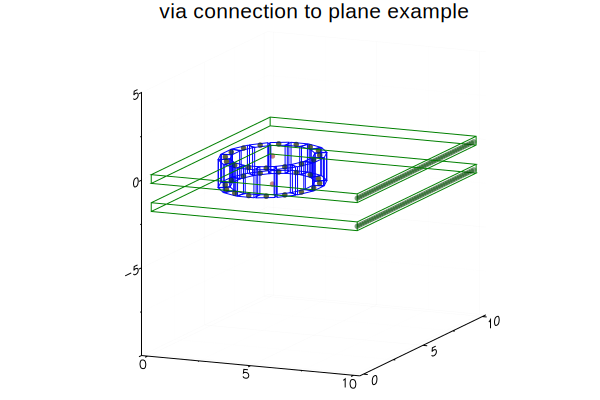

In [5]:
# plot results
using Plots;gr()
plot(via_plane_example)